In [135]:
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


In [6]:
import torch
import torch_scatter
import torch_sparse
import torch_geometric
import tqdm.auto
import os
from operator import itemgetter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import regex as rex
import math
from collections import defaultdict
from scipy import stats
import matplotlib.cm as cm

import csv

In [2]:
path = "/content/drive/MyDrive/output_with_stats_columns.csv"
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
local_path = "output_with_stats_columns.csv"
local_path = "output_attr_stats.csv"

In [7]:
df = pd.read_csv(local_path)
df = df.iloc[0:2000]

In [8]:
def remove_outliers(df):
    new_d = df
    nb_char = df['nb_chars']
    nb_word = df['nb_words']
    nb_char_np = nb_char.to_numpy()
    nb_word_np = nb_word.to_numpy()

    std_mad_char = stats.median_absolute_deviation(nb_char_np)
    std_mad_word = stats.median_absolute_deviation(nb_word_np)

    del_list = []
    dd = df[(df['nb_chars'] < (3*nb_char_np)) & (df['nb_words'] < (3*nb_word_np))]
    display(dd)
    return dd

In [9]:
display(df)
for col in df.columns:
    print(col)

,filenm,From,Sent,To,CC,Bcc,Subject,Attachments,Importance,isThread,...,cc,nb_words,nb_chars,body_len,body,mn_nb_words,std_nb_words,mn_nb_chars,std_nb_chars,email_count
0,29142_fn_10-4-Cascade-2015-1-0_ln_42056.txt,shaneamoniz,"Friday, May 08, 2015 11:38 AM",brooks@culpeppercc.com,rgrindler@101tally.com;davidrosenfeld,NaN,Edison RFI's,RFI 008 Response.pdf; RFI 042 Response.pdf; RF...,NaN,False,...,Ryan Grindler rgrindler@101tally.com ; Rosenf...,55,338,392,"Response.pdf Brooks, attached is our response ...",196.566667,750.078234,1132.166667,4195.776753,30
1,41353_fn_10-3-Cascade-2014-2-0_ln_16811.txt,markbeaudoin,"Tuesday, August 19, 2014 5:21 PM",kristencoons,patrickhurley,NaN,RE: Revised lease,NaN,NaN,False,...,Patrick Hurley,3,9,11,Good by me!,155.288462,899.776839,818.348558,4797.418093,416
2,01216_fn_17-2-IB2013-1-0_ln_44062.txt,kenmorris,"Tuesday, May 28, 2013 1:22 PM",kim@inkbridge.com,deborahcraig;lindsayjordan;jessicamiller;jayto...,NaN,Proposed Imagine Schedule,NaN,NaN,False,...,Jon Brown; Mathieu Cavell; CMR_Team CMR_Team; ...,401,1928,2328,"Kim, See comments in blue regarding the propos...",483.698113,1078.306464,2747.301887,6354.713186,53
3,32414_fn_32-1-PaigeCS-1-1_ln_18843.txt,director@springtimetallahassee.com,"Wednesday, March 15, 2017 5:32 PM",alisonfaris,paigecarter;edwardkring;paradespringtimetallah...,NaN,RE: Springtime Parade,NaN,NaN,False,...,Paige Carter-Smith; Parade Springtime Tallahas...,279,1445,1723,"Hi Alison, Dont apologize, I know its a lot to...",372.461538,619.810941,1888.615385,3156.748922,13
4,56710_fn_31-2-GaryYordon2-3_ln_41027.txt,paullamaster,"Sunday, June 7, 2015 at 1:33:39 PM Eastern Day...",gil.ziffer@talgov.com;rick.fernandez@talgov.co...,gary@zprgroup.com,NaN,Tony Carvajal: Develop strategy to get ahead o...,NaN,NaN,False,...,alan.williams@myfloridahouse.gov; gary@zprgrou...,110,561,670,Highly recommend you take a moment out of your...,184.072937,127.504495,1288.858746,648.333393,3030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,33108_fn_9-2-Adam-Corey2013-1-0_ln_13380.txt,rickmccraw,"Wednesday, May 08, 2013 2:24 PM",genecrawford;jessejabot;dandonovan;steveshafer...,invalid_nan,NaN,RE: May 9th Meeting of the Kleman Plaza Design...,KPDRB November 8 2012_ DRAFT Minutes.pdf; KPDR...,NaN,False,...,INVALID_TYPE,103,595,697,DRAFT Minutes.pdf Dear Kleman Plaza Design Rev...,500.606061,1628.451088,2641.613054,8619.135153,429
1996,21584_fn_34-2-ScottMaddox2_ln_38388.txt,wade.bishop@talgov.com,"Tuesday, June 25, 2013 9:31 AM",invalid,invalid_nan,NaN,news clip,NaN,NaN,False,...,INVALID_TYPE,125,793,917,24June13wctv1 Starmetro & bicyclists-keeping b...,97.300613,60.763469,643.748466,357.386956,163
1997,14092_fn_23-6-PaigeCarter-Smith2017-2-0_ln_367...,timlee,"Monday, February 20, 2017 2:53 PM",allmailboxes,invalid_nan,NaN,Email Spam,NaN,NaN,False,...,INVALID_TYPE,1,0,0,NaN,124.463087,135.107441,639.395973,690.248788,149
1998,51906_fn_34-5-ScottMaddox5_ln_59547.txt,allison.fleming@talgov.com,"Tuesday, October 15, 2013 11:38 AM",carriehughes,invalid_nan,NaN,Accepted: Commissioner Briefing - Evening Ros...,NaN,NaN,False,...,INVALID_TYPE,1,0,0,NaN,56.192571,72.060620,310.296188,370.403156,1023


filenm
From
Sent
To
CC
Bcc
Subject
Attachments
Importance
isThread
isAutoMessage
isDisplacement
hasAllCapLine
hasBadDate
Body
timestamp
date_sent
time_sent
cc
nb_words
nb_chars
body_len
body
mn_nb_words
std_nb_words
mn_nb_chars
std_nb_chars
email_count


In [10]:
def add_To_CC_num(df):
  """
  ADD COMMENTS. One line stating what the function does
  
  Arguments
  ---------
  df (DataFrame)
  
  Return
  ------
    New DataFrame object with columns num_To and num_CC
  """
  num_to = []
  num_cc = []
  for i in range(len(df)):
    x1 = 0
    x2 = 0
    e = df.iloc[[i]]
    to = e['To']
    cc = e['CC']
    result_to = re.findall('\(.*?\)', str(to))
    result_cc = re.findall('\(.*?\)', str(cc))
    
    if len(result_to) > 0:
      x1 += len(result_to)

    if len(result_cc) > 0:
      x2 += len(result_cc)
    
    num_to.append(x1)
    num_cc.append(x2)
  dd = df
  dd['num_To'] = num_to
  dd['num_CC'] = num_cc
  return dd


In [11]:
def new_add_To_CC_num(df):
  """
  ADD COMMENTS. One line stating what the function does
  
  Arguments
  ---------
  df (DataFrame)
  
  Return
  ------
    New DataFrame object with columns num_To and num_CC
  """
  num_to = []
  num_cc = []
  to_list = df.To.values
  cc_list = df.CC.values
  dd = df.copy()
    
  for to in to_list:
        split = to.split(";")
        num_to.append(len(split))
  for cc in cc_list: 
        split = cc.split(";")
        num_cc.append(len(split))
 
  dd['num_To'] = num_to
  dd['num_CC'] = num_cc
  return dd


In [35]:
#df2 = add_To_CC_num(df)

In [12]:
df3 = new_add_To_CC_num(df)

In [22]:
display(df3[["num_To", "To"]])
df3.loc[4].To;

,num_To,To
0,1,brooks@culpeppercc.com
1,1,kristencoons
2,1,kim@inkbridge.com
3,1,alisonfaris
4,11,gil.ziffer@talgov.com;rick.fernandez@talgov.co...
...,...,...
1995,20,genecrawford;jessejabot;dandonovan;steveshafer...
1996,1,invalid
1997,1,allmailboxes
1998,1,carriehughes


In [23]:
df_test = df3.iloc[0:2000]
display(df_test)
display(df_test.index)

,filenm,From,Sent,To,CC,Bcc,Subject,Attachments,Importance,isThread,...,nb_chars,body_len,body,mn_nb_words,std_nb_words,mn_nb_chars,std_nb_chars,email_count,num_To,num_CC
0,29142_fn_10-4-Cascade-2015-1-0_ln_42056.txt,shaneamoniz,"Friday, May 08, 2015 11:38 AM",brooks@culpeppercc.com,rgrindler@101tally.com;davidrosenfeld,NaN,Edison RFI's,RFI 008 Response.pdf; RFI 042 Response.pdf; RF...,NaN,False,...,338,392,"Response.pdf Brooks, attached is our response ...",196.566667,750.078234,1132.166667,4195.776753,30,1,2
1,41353_fn_10-3-Cascade-2014-2-0_ln_16811.txt,markbeaudoin,"Tuesday, August 19, 2014 5:21 PM",kristencoons,patrickhurley,NaN,RE: Revised lease,NaN,NaN,False,...,9,11,Good by me!,155.288462,899.776839,818.348558,4797.418093,416,1,1
2,01216_fn_17-2-IB2013-1-0_ln_44062.txt,kenmorris,"Tuesday, May 28, 2013 1:22 PM",kim@inkbridge.com,deborahcraig;lindsayjordan;jessicamiller;jayto...,NaN,Proposed Imagine Schedule,NaN,NaN,False,...,1928,2328,"Kim, See comments in blue regarding the propos...",483.698113,1078.306464,2747.301887,6354.713186,53,1,10
3,32414_fn_32-1-PaigeCS-1-1_ln_18843.txt,director@springtimetallahassee.com,"Wednesday, March 15, 2017 5:32 PM",alisonfaris,paigecarter;edwardkring;paradespringtimetallah...,NaN,RE: Springtime Parade,NaN,NaN,False,...,1445,1723,"Hi Alison, Dont apologize, I know its a lot to...",372.461538,619.810941,1888.615385,3156.748922,13,1,3
4,56710_fn_31-2-GaryYordon2-3_ln_41027.txt,paullamaster,"Sunday, June 7, 2015 at 1:33:39 PM Eastern Day...",gil.ziffer@talgov.com;rick.fernandez@talgov.co...,gary@zprgroup.com,NaN,Tony Carvajal: Develop strategy to get ahead o...,NaN,NaN,False,...,561,670,Highly recommend you take a moment out of your...,184.072937,127.504495,1288.858746,648.333393,3030,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,33108_fn_9-2-Adam-Corey2013-1-0_ln_13380.txt,rickmccraw,"Wednesday, May 08, 2013 2:24 PM",genecrawford;jessejabot;dandonovan;steveshafer...,invalid_nan,NaN,RE: May 9th Meeting of the Kleman Plaza Design...,KPDRB November 8 2012_ DRAFT Minutes.pdf; KPDR...,NaN,False,...,595,697,DRAFT Minutes.pdf Dear Kleman Plaza Design Rev...,500.606061,1628.451088,2641.613054,8619.135153,429,20,1
1996,21584_fn_34-2-ScottMaddox2_ln_38388.txt,wade.bishop@talgov.com,"Tuesday, June 25, 2013 9:31 AM",invalid,invalid_nan,NaN,news clip,NaN,NaN,False,...,793,917,24June13wctv1 Starmetro & bicyclists-keeping b...,97.300613,60.763469,643.748466,357.386956,163,1,1
1997,14092_fn_23-6-PaigeCarter-Smith2017-2-0_ln_367...,timlee,"Monday, February 20, 2017 2:53 PM",allmailboxes,invalid_nan,NaN,Email Spam,NaN,NaN,False,...,0,0,NaN,124.463087,135.107441,639.395973,690.248788,149,1,1
1998,51906_fn_34-5-ScottMaddox5_ln_59547.txt,allison.fleming@talgov.com,"Tuesday, October 15, 2013 11:38 AM",carriehughes,invalid_nan,NaN,Accepted: Commissioner Briefing - Evening Ros...,NaN,NaN,False,...,0,0,NaN,56.192571,72.060620,310.296188,370.403156,1023,1,1


RangeIndex(start=0, stop=2000, step=1)

In [24]:
def new_create_node_list(df):
  #this takes in a pandas dataframe and returns a list of node names
  # the node names are either names or emails
  # Invalid nodes should be removed (NOT YET DONE)
  
  to_list = df.To.values
  cc_list = df.CC.values
  from_list = df.From.values
  node_set = set()
  
  for el in from_list:
        node_set.add(el)
        
  for els in to_list:
    split = els.split(";")
    for el in split:
        node_set.add(el)
    
  for els in cc_list:
    split = els.split(";")
    for el in split:
        node_set.add(el)
        
  # Remove non-strings
  node_list = []
  for n in node_set:
    if type(n) == str:  # NaN is a float
        if rex.match(r'.*invalid', n.lower()): continue
        if rex.match(r'.*@', n):
            node_list.append(n)
        
  node_list.sort()

  return node_list #returns a list of str

In [25]:
nodes = new_create_node_list(df)

In [26]:
len(nodes)

4089

In [28]:
# some nodes are cleary wrong: e.g.: 
#    '850)545-2095edward.kring@talgov.comsentfrommyiphonethanks,eddieedwardmarwkringci-zenengagementambassador,departmentofcommunica-onsoﬃce:(850)891-8081cell:(850',
nodes;

In [146]:
def create_edge_list(df, nodes):
  #takes in a dataframe and a list of str
  #df is supposed to be the email dataset and nodes is the nodes generated from the dataset
  edgelist = set()
  #creates a set so that there are only unique edges
  #maybe in the future it can account for multiple edges

  # THIS CODE IS EITHER WRONG OR VERY INEFFICIENT
  
  for node in nodes:
    #it goes through the nodes and gets all of the emails that were sent from that node
    if node != '':
      from_who = df.loc[df['From'] == node]
      r = len(from_who.index)

      for i in range(r):
        #iterates through all of the emails that were sent from a particular node
        #and saves all of the values encased in () and appends it to the edge list
        j = from_who.iloc[i:i+1]
        x = j['To']
        y = j['CC']
        #display(x)
        #display('-----')
        index_1 = nodes.index(node)
        for xi in x:
          #display(xi)
          #goes through the values in To and adds it to the edge list 
          if xi != '':
            result = re.findall('\(.*?\)', xi)
            for s in result:
              if s in nodes:
                index_2 = nodes.index(s)
                edgelist.add(tuple([index_1, index_2]))
        
        for yi in y:
          #this is done for CC as well as From
          if yi != '':
            result = re.findall('\(.*?\)', yi)
            for s in result:
              if s in nodes:
                index_2 = nodes.index(s)
                edgelist.add(tuple([index_1, index_2]))
        
  #this returns an edge list where the index is formatted [sender, reciever]
  return list(edgelist)

In [145]:
def create_node_list(df):
  #this takes in a pandas dataframe
  
  to_list = []
  from_list = []
  CC_list = []

  alist = df['To']
#this gets all of the values under To for the df 

  for x in alist:# this interates through the values for To and
    result = re.findall('\(.*?\)', x)#appends all of the values in it that are contained in ()
    for s in result:
      if '@' in s:
        to_list.append(s)


  blist = df['From']#the same that is done for To is done for From  and CC

  for x in blist:
    result = re.findall('\(.*?\)', x)
    for s in result:
      if '@' in s:
        from_list.append(s)


  clist = df['CC']

  for x in clist:
    result = re.findall('\(.*?\)', x)
    for s in result:
      if '@' in s:
        CC_list.append(s)

  final_list = to_list + from_list #+ CC_list #The lists are combined together

  Myfinallist = sorted(set(final_list)) #this takes out any repeating values

  return Myfinallist #returns a list of str

In [128]:
def new_create_edge_list(df, nodes):
  # XXX
  #takes in a dataframe and a list of str
  #df is supposed to be the email dataset and nodes is the nodes generated from the dataset
  edgelist = []
  #creates a set so that there are only unique edges
  #maybe in the future it can account for multiple edges
  
  from_list = df.From
  to_list = df.To
  cc_list = df.CC
    
  for f,to,cc in zip(df.From, df.To, df.CC):
     # Unique list of names
     if type(f) != str: continue
     receiver_list = list(set(to.split(";") + cc.split(";")))
     for rec in receiver_list:
        if type(rec) != str: continue
        if rex.match(r'.*invalid', rec.lower()): continue
        edgelist.append((f, rec))
        
  return edgelist

In [75]:
len(new_create_edge_list(df, nodes))

211592

In [77]:
def get_rid_of_NaN(val):
  if math.isnan(val):
    return 0
  return val
  
def get_rid_of_emp_str(s):
  if s == '':
    return 0
  else:
    return len(s)

In [78]:
#this is a rewrite with new column val

## NOTE: Since the operations you do are the same for various lists, you should write
# a single function and call the function multiple times. 

def create_node_meta_list(df, nodes):
  mean_char_list = []
  mean_word_list = []
  mean_to_list = []
  mean_cc_list = []
  std_char_list = []
  std_word_list = []
  std_to_list = []
  std_cc_list = []
  num_sent_list = []
  node_meta_list = []
  for node in nodes:
    to_data = []
    cc_data = []
    char_data = []
    word_data = []

    from_who = df.loc[df['From'] == node]
    to_who = df.loc[df['To'] == node]
    cc_who = df.loc[df['CC'] == node]

    num_recieved = len(to_who) + len(cc_who)

    num_sent = len(from_who)

    r = len(from_who.index)
    for i in range(r):
        #iterates through all of the emails that were sent from a particular node
        #and saves all of the values encased in () and appends it to the edge list
      j = from_who.iloc[i:i+1]
      #display(j)
      to_data.append(int(j['num_To']))
      cc_data.append(int(j['num_CC']))
      char_data.append(int(j['nb_chars']))
      word_data.append(int(j['nb_words']))


      
    char_data = np.array(char_data)
    word_data = np.array(word_data)

    to_data = np.array(to_data)
    cc_data = np.array(cc_data)

    mean_char = np.mean(char_data)
    mean_word = np.mean(word_data)

    std_char = np.std(char_data)
    std_word = np.std(word_data)

    mean_to = np.mean(to_data)
    mean_cc = np.mean(cc_data)

    std_to = np.std(to_data)
    std_cc = np.std(cc_data)

    mean_char = get_rid_of_NaN(mean_char)
    mean_word = get_rid_of_NaN(mean_word)
    mean_to = get_rid_of_NaN(mean_to)
    mean_cc = get_rid_of_NaN(mean_cc)
    std_char = get_rid_of_NaN(std_char)
    std_word = get_rid_of_NaN(std_word)
    std_to = get_rid_of_NaN(std_to)
    std_cc = get_rid_of_NaN(std_cc)

    inloop_node_meta = [mean_char, mean_word, mean_to, mean_cc, std_char, std_word, std_to, std_cc, num_sent]

    mean_char_list.append(mean_char)
    mean_word_list.append(mean_word)
    mean_to_list.append(mean_to)
    mean_cc_list.append(mean_cc)
    std_char_list.append(std_char)
    std_word_list.append(std_word)
    std_to_list.append(std_to)
    std_cc_list.append(std_cc)
    num_sent_list.append(num_sent)

    node_meta_list.append(inloop_node_meta)
  return [mean_char_list, mean_word_list, mean_to_list, mean_cc_list, std_char_list, std_word_list, std_to_list, std_cc_list, num_sent_list]

In [79]:
def get_node_recieved_list(df, nodes):
  recieved_email = []
  for node in nodes: 
    alist = df['To']
    blist = df['CC']
    rec_num = 0

    for x in alist:
      result = re.findall('\(.*?\)', x)
      if node in result:
        rec_num += 1

    for x in blist:
      result = re.findall('\(.*?\)', x)
      if node in result:
        rec_num += 1

    recieved_email.append(rec_num)
  return recieved_email

In [80]:
def scale_meta(meta):
  scaled_meta = []
  for col in range(len(meta)):
    x = np.array(meta[col])
    max = np.amax(x)
    scaled_meta.append(x/max)
  return scaled_meta


In [81]:
def create_bi_class(df, node_meta):
  """
  What does this function do? 
  
  Arguments
  ---------
  df (DataFrame)
  node_meta (????)
  
  Returns
  -------
  bi_class (type???)
      ???? what is this variable?  Describe it. 
  """
  bi_class = []
  mean_list = np.array(node_meta)
  mean_val = np.mean(mean_list)
  for node in node_meta:
    if node > mean_val:
      bi_class.append(1)
    else:
      bi_class.append(0)
  return bi_class

In [82]:
def create_node_list_txt(node, node_meta, rec_list, bi_class_list):
  #takes a list that has the node list, the sent list, and the recieved list
  #this is a new version of create_nodes_txt that incorporates the node metadata
  torch.manual_seed(0)
  with open('nodes.txt','w') as f:
    for i in range(len(node)):
      #display(node)
      X_str = ' '.join([str(element.item()) for element in .5 + torch.randn((16))])
      s = ''
      for n in range(len(node_meta[0])):
        s = s + str(node_meta[i][n]) + ' '
      #f.write( str(nodes[0][i]) + ' ' + s + X_str +'\n')
      f.write(str(i) + ' ' + str(bi_class_list[i]) + ' ' + s + str(rec_list[i]) + '\n')

In [83]:
def create_edges_txt(edges):
  #creates a txt file that is just the edge list
  with open('edges.txt','w') as f:
    for edge in edges:
      f.write(f'{edge[0]} {edge[1]} {1}\n')
      #print(edge[0])

In [110]:
def remove_outliers(df):
    # Rewritten by G. Erlebacher
    #new_d = df ### BAD
    new_d = df.copy()
    nb_char = df['nb_chars']
    nb_word = df['nb_words']
    nb_char_np = nb_char.to_numpy()
    nb_word_np = nb_word.to_numpy()
    
    mad_char = nb_char.median()
    mad_word = nb_word.median()
    std_char = nb_char.mad()
    std_word = nb_word.mad()
    
    check_char = nb_char < (mad_char + 3*std_char)
    check_word = nb_word < (mad_word + 3*std_word)
    new_d = new_d[check_char & check_word]
    return new_d

    #std_mad_char = stats.median_absolute_deviation(nb_char_np)
    #std_mad_word = stats.median_absolute_deviation(nb_word_np)

    # We define an outlier as lying out the mean + 3*sigma band, even if the distribution is not normal
    del_list = []
    dd = df[(df['nb_chars'] < (3*nb_char_np)) & (df['nb_words'] < (3*nb_word_np))]
    return dd
    

In [111]:
# Demonstration of why yy = xx is a bad idea
xx = df.copy()
yy = xx
yy['gustavo'] = yy['From']
print(xx.columns)

Index(['filenm', 'From', 'Sent', 'To', 'CC', 'Bcc', 'Subject', 'Attachments',
       'Importance', 'isThread', 'isAutoMessage', 'isDisplacement',
       'hasAllCapLine', 'hasBadDate', 'Body', 'timestamp', 'date_sent',
       'time_sent', 'cc', 'nb_words', 'nb_chars', 'body_len', 'body',
       'mn_nb_words', 'std_nb_words', 'mn_nb_chars', 'std_nb_chars',
       'email_count', 'num_To', 'num_CC', 'gustavo'],
      dtype='object')


# Comments from G. Erlebacher
* how do you check your code (state in report)
* After adding additional columns, did you save your file so the next time you need it, you do not have to recompute everything? That is a form of caching. 
* Make sure you create a function library. Avoid creating functions in the jupyter code. Move them to the library once they work. 
* Make sure your functions are commented. Get into the habit. 

In [113]:
df_test_wo_outliers = remove_outliers(df_test)

In [114]:
df_test;

# Gustavo: Why are you not using df_test_wo_outliers in the following cell and below?
* the data is not scaled in df_test_wo_outliers (at least the  std_nb_chars is not scaled
* num_to and num_CC are not scaled either to lie between [0,1]

In [117]:
df_nodes_test = new_create_node_list(df_test)
df_edges_test = new_create_edge_list(df_test, df_nodes_test)
df_node_meta_test = create_node_meta_list(df_test, df_nodes_test)

# All zeros
df_rec_list_test = get_node_recieved_list(df_test, df_nodes_test)

# What is this? 
df_node_meta_test.append(df_rec_list_test)

nodes_test = df_nodes_test  # a list not a dataframe)
edges_test = df_edges_test

scaled_df_node_meta_test = scale_meta(df_node_meta_test)

<ipython-input-80-1d47d51a347e>:6: RuntimeWarning: invalid value encountered in true_divide
  scaled_meta.append(x/max)


In [126]:
df_test_wo_outliers.columns

Index(['filenm', 'From', 'Sent', 'To', 'CC', 'Bcc', 'Subject', 'Attachments',
       'Importance', 'isThread', 'isAutoMessage', 'isDisplacement',
       'hasAllCapLine', 'hasBadDate', 'Body', 'timestamp', 'date_sent',
       'time_sent', 'cc', 'nb_words', 'nb_chars', 'body_len', 'body',
       'mn_nb_words', 'std_nb_words', 'mn_nb_chars', 'std_nb_chars',
       'email_count', 'num_To', 'num_CC'],
      dtype='object')

In [122]:
bi_classes_test = []
bi_classes_test_scaled = []
for i in range(len(df_node_meta_test)):   # df_node_meta_test is a list! Poor naming.
  bi_classes_test.append(create_bi_class(df_test, df_node_meta_test[i]))
  bi_classes_test_scaled.append(create_bi_class(df_test, scaled_df_node_meta_test[i]))

In [161]:
df_nodes_test_wo_outliers = create_node_list(df_test_wo_outliers)
df_edges_test_wo_outliers = create_edge_list(df_test_wo_outliers, df_nodes_test_wo_outliers)
df_node_meta_test_wo_outliers = create_node_meta_list(df_test_wo_outliers, df_nodes_test_wo_outliers)
df_rec_list_test_wo_outliers = get_node_recieved_list(df_test_wo_outliers, df_nodes_test_wo_outliers)
df_node_meta_test_wo_outliers.append(df_rec_list_test_wo_outliers)


scaled_df_node_meta_test_wo_outliers = scale_meta(df_node_meta_test_wo_outliers)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [162]:
bi_classes_test_wo_outliers = []
bi_classes_test_wo_outliers_scaled = []
for i in range(len(df_node_meta_test_wo_outliers)):
  bi_classes_test_wo_outliers.append(create_bi_class(df_test_wo_outliers, df_node_meta_test_wo_outliers[i]))
  bi_classes_test_wo_outliers_scaled.append(create_bi_class(df_test_wo_outliers, scaled_df_node_meta_test_wo_outliers[i]))

In [163]:
def create_node_list_txt(node, node_meta, bi_class_list):
  #takes a list that has the node list, the sent list, and the recieved list
  #this is a new version of create_nodes_txt that incorporates the node metadata
  torch.manual_seed(0)
  with open('nodes.txt','w') as f:
    for i in range(len(node)):
      s = ''
      for n in range(len(node_meta)):
        s = s + str(node_meta[n][i]) + ' '
      f.write(str(i) + ' ' + str(bi_class_list[i]) + ' ' + s + '\n')

In [164]:
def print_acc(predictions, bi_class):
  x = 0
  for i in range(len(bi_class)):
    if predictions.argmax(dim=1)[i] == bi_class[i]:
      x += 1
  acc = 100 * x / len(bi_class) 
  display(acc)
  return acc

In [199]:
### A simple Message-Passing network w/ common aggregation schemes.
class Simple_GNN(torch.nn.Module):

    def __init__(self,in_features,int_features,out_features,depth,aggregation_mode = 'mean',dropout_prob = .1):
        '''
        [in_features]       - # of input features.
        [int_features]      - # of features in message-passing layers. Within the 
                              GNN literature, this is typically a constant.
        [out_features]      - # of output features. Corresponds to # of classes,
                              regression targets, etc.
        [depth]             - # of message-passing layers. 
        [aggregation_mode]  - choice of aggregation scheme. Can be 'mean',
                              'sum', 'max', or 'none'
        [dropout_prob]      - probability used for Dropout (see Srivastava et al., 2017)
        '''

        super(Simple_GNN,self).__init__()
        assert aggregation_mode in ['mean','sum','max','none']

        self.f_in = torch.nn.Linear(in_features,int_features)
        self.f_int = torch.nn.ModuleList([torch.nn.Sequential(*[torch.nn.Linear(int_features,int_features),
                                                                torch.nn.LeakyReLU(),
                                                                torch.nn.Dropout(dropout_prob)])
                                              for _ in range(depth)])
        self.f_out = torch.nn.Linear(int_features,out_features)

        if aggregation_mode == 'mean': self.agg = torch_scatter.scatter_mean
        elif aggregation_mode == 'sum': self.agg = torch_scatter.scatter_sum
        elif aggregation_mode == 'max': self.agg = torch_scatter.scatter_max

        self.aggregation_mode = aggregation_mode

    def forward(self,node_features,edge_index,edge_weights = None):
        '''
        [node_features]  - Matrix of node features. First (batch) dimension corresponds
                           to nodes; second to features.
        [edge_index]     - Edge list representation of a graph. Shape [num_edges]x2
        [edge_weights]   - Optional scalar edge weights. Shape [num_edges,1]
        '''

        node_features = self.f_in(node_features)
        for idx,layer in enumerate(self.f_int):
            if self.aggregation_mode != 'none':
                if edge_weights != None:
                    #display('here')
                    qqq = edge_weights * node_features[edge_index[:,0]]
                    qqq2 = edge_index[:,1]
                    
                    #display(len(edge_weights * node_features[edge_index[:,0]]))
                    #display(len(edge_index[:,1]))
                    #display(len(torch_scatter.scatter_mean(edge_weights * node_features[edge_index[:,0]],edge_index[:,1],dim=0)))


                    #this part right here is where the errors come from
                    #the output is supposed to be equal to the number of nodes which in this case is 4571 but it returns 4569
                    #when I do aggregation with the without outliers set that has less nodes it's still exactly 2 less
                    
                    aggregated_node_features = self.agg(edge_weights * node_features[edge_index[:,0]],
                                                                    edge_index[:,1],dim=0)
                    
                else:
                    aggregated_node_features = self.agg(node_features[edge_index[:,0]],edge_index[:,1],dim=0) 
            else:
                aggregated_node_features = node_features
                
            if isinstance(aggregated_node_features,tuple): 
                #display('here2')
                aggregated_node_features = aggregated_node_features[0]

            #display(len(node_features))
            #display(len(layer(aggregated_node_features)))
            #display(len(aggregated_node_features))

            node_features = node_features + layer(aggregated_node_features)
        return self.f_out(node_features),node_features

In [200]:
### General purpose object for storing graph data
class Graph(object):
    def __init__(self,edge_index = None,edge_metadata = None,node_metadata = None):
        self.edge_index = edge_index
        self.edge_metadata = edge_metadata
        self.node_metadata = node_metadata
        self.num_nodes = None

    def read_edges(self,filepath):
        ''' Edges should be stored as follows:
            0 1 3.1 2.0
            0 2 1.0 0.0
            1 0 3.1 2.0
            ...
        where the first two columns are node indices and the remainder
        are edge features. '''

        with open(filepath,'r') as f:
          edges = torch.Tensor([list(map(float,line.strip().split(' '))) \
                                         for line in f.readlines()])
        if edges.shape[1] == 2:
          self.edge_index = edges.long()
        elif edges.shape[1] >= 3:
          self.edge_index = edges[:,:2].long()
          self.edge_metadata = edges[:,2::]
                      
    def read_node_metadata(self,filepath,padding_value = 0.0):
        ''' Nodes should be stored as follows:
            0 4.1 9.2 1.1 ...
            2 3.3 1.1 9.0 ...
            ...
        where the first column is the node index and the remainder
        are node features. If a node is not listed but should still 
        clearly exist (e.g, nodes '0' and '2' are present in the file
        but not node '1'), the missing node is given constant features 
        set to [padding_value]'''

        with open(filepath,'r') as f:
          nodes = torch.Tensor([list(map(float,line.strip().split(' '))) \
                                         for line in f.readlines()])
          
        self.num_nodes = 1 + nodes[:,0].max().long()
        node_metadata = padding_value * torch.ones((self.num_nodes,nodes.shape[1]-1))
        node_metadata[nodes[:,0].long()] = nodes[:,1::]   #GE

        self.node_metadata = node_metadata

In [201]:
### Call to fit node-level model and save results
class GNN_Node_Trainer(object):
    def __init__(self,graph,**kwargs):
        '''
        [graph]  - Instance of _Graph_. Expects to be fully initialized. 
        ******* Optional Arguments *********
        [train_index],[test_index] - Partitions graph into train and test sets.
                                     Defaults to random 60%/40% split.
        [num_epochs]               - # of epochs to train. Defaults to 20.
        [loss_func]                - Loss function to minimize. Defaults to 
                                     Cross Entropy.
        [random_seed]              - Defaults to 0. 
        '''
        torch.manual_seed(kwargs.get('random_seed',0))

        assert isinstance(graph,Graph)        
        self.graph = graph

        ### If train_index and test_index are not provided, we randomly
        ### select a train/test split.
        r = torch.randperm(graph.num_nodes)
        self.train_index,self.test_index = kwargs.get('train_index',r[:int(.6 * len(r))]),\
                                  kwargs.get('test_index',r[int(.6 * len(r))::])

        self.num_epochs = kwargs.get('num_epochs',20)
        self.loss_func = kwargs.get('loss_func',lambda x,y,*args: torch.nn.functional.cross_entropy(x,y.long()))

    def __call__(self,model,**kwargs):
        '''
        [model]  - i.e, our GNN 
        ******* Optional Arguments *********
        [lr],[beta],['weight_decay'] - Optimizer parameters. Default to 1e-3, (.9,.999), 
                                       and 1e-2.
        [quiet]                      - Boolean. Disables logging to stdout
        [metrics_callback]           - Dict of functions to compute additional metrics.
        [title]                      - Saves metrics and model ckpt to 'gnn_results/[title]'
                                       at end of training. Defaults to 'run_0'.
        [device]                     - Should be 'cpu' or 'cuda:0'. Defaults to 'cpu'.

        Note: We assume the first column of 'self.graph.node_metedata' to be our 
        target values.
        '''
        opt = torch.optim.Adam(model.parameters(),lr=kwargs.get('lr',1e-3),
                                        betas = kwargs.get('beta',(0.9, 0.999)),
                                        weight_decay=kwargs.get('weight_decay',1e-2)
                                )

        device = torch.device(kwargs.get('device','cpu'))
        model.to(device)

        ### Load data to device.
        node_features,edge_index,edge_weights = self.graph.node_metadata.to(device),\
                                                    self.graph.edge_index.to(device),\
                                                    self.graph.edge_metadata.to(device)
        X,Y = node_features[:,1::].to(device),node_features[:,0].to(device)

        metrics = {'train_loss':[],'test_loss':[]}
        metrics_callback = kwargs.get('metrics_callback',{})
        for key in metrics_callback.keys(): 
            metrics['train_'+key] = []
            metrics['test_'+key] = []

        pbar = tqdm.tqdm(range(self.num_epochs),position=0,disable=kwargs.get('quiet',False))
        epoch_list = []
        train_loss_list = []
        test_loss_list = []
        for idx in pbar:
            ### Get predictions and compute losses over train and test sets.
            #display(len(node_features))
            #display(len(edge_weights))
            #display(len(edge_index))
            #display(len(X))
            predictions,_ = model(X,edge_index,edge_weights)
            train_loss,test_loss = self.loss_func(predictions[self.train_index],Y[self.train_index],
                                                  edge_index,edge_weights),\
                                          self.loss_func(predictions[self.test_index],Y[self.test_index],
                                                  edge_index,edge_weights)
          
            epoch_list.append(idx)
            train_loss_list.append(train_loss.item())
            test_loss_list.append(test_loss.item())

            pbar.set_description(f'Train Loss: {train_loss.item():.3f}\tTest Loss: {test_loss.item():.3f}')
            if torch.isnan(train_loss): raise ValueError('Training loss is NaN')

            ### Backpropagate w.r.t training loss
            train_loss.backward()
            opt.step()
            opt.zero_grad()

            ### Save losses and compute additional metrics
            metrics['train_loss'].append(train_loss.item())
            metrics['test_loss'].append(test_loss.item())
            for key in metrics_callback.keys():
                metrics['train_'+key].append(metrics_callback[key](predictions[self.train_index],Y[self.train_index],
                                                        edge_index,edge_weights))
                metrics['test_'+key].append(metrics_callback[key](predictions[self.test_index],Y[self.test_index],
                                                        edge_index,edge_weights))

        plt.figure()
        l1 = plt.plot(epoch_list, train_loss_list, c='red')
        l2 = plt.plot(epoch_list, test_loss_list, c='blue')
        plt.legend((l1,l2),('train loss','test loss'))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Loss vs epoch')
        plt.savefig('loss_epoch.png')
        plt.show()

        os.makedirs('gnn_results',exist_ok=True)
        title = kwargs.get('title','run_0')
        os.makedirs('gnn_results/{}'.format(title),exist_ok=True)
        torch.save(model.state_dict(),'gnn_results/{}/ckpt'.format(title))
        torch.save(metrics,'gnn_results/{}/metrics'.format(title))

        return predictions

torch.Size([4571, 11])

Train Loss: 0.159	Test Loss: 0.112: 100%|██████████| 200/200 [00:05<00:00, 38.92it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950afebb90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950afb3710>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


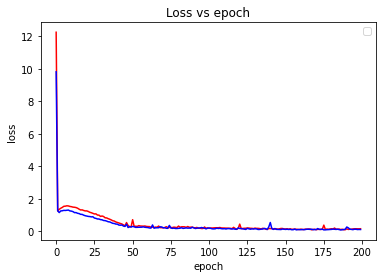

Train Class #: tensor([2489,  253])
Test Class #: tensor([1631,  198])


98.77488514548239

<Figure size 432x288 with 0 Axes>

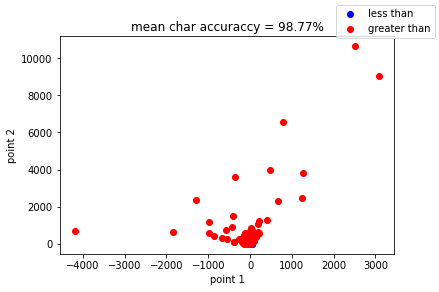

torch.Size([4571, 11])

Train Loss: 0.125	Test Loss: 0.093: 100%|██████████| 200/200 [00:05<00:00, 39.64it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508164b10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508164bd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


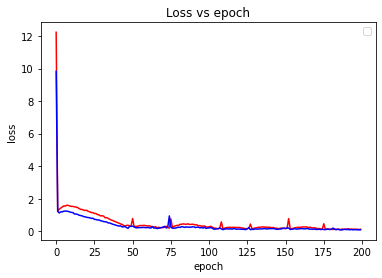

Train Class #: tensor([2489,  253])
Test Class #: tensor([1629,  200])


98.88427040035003

<Figure size 432x288 with 0 Axes>

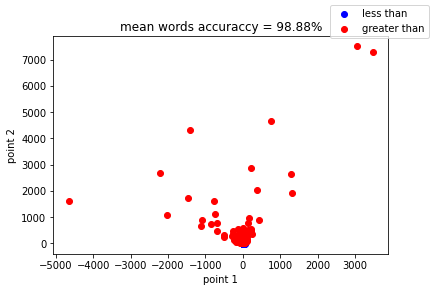

torch.Size([4571, 11])

Train Loss: 0.455	Test Loss: 1.007: 100%|██████████| 200/200 [00:04<00:00, 42.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950bf99150>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950c1ad890>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


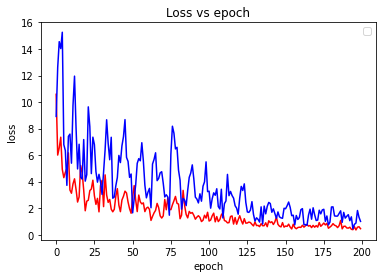

Train Class #: tensor([2559,  183])
Test Class #: tensor([1690,  139])


95.09954058192956

<Figure size 432x288 with 0 Axes>

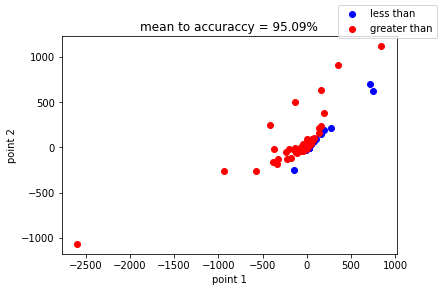

torch.Size([4571, 11])

Train Loss: 0.379	Test Loss: 1.170: 100%|██████████| 200/200 [00:04<00:00, 43.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950a4ec7d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950c24a490>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


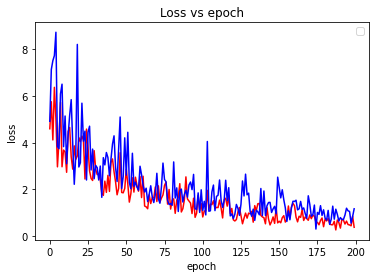

Train Class #: tensor([2645,   97])
Test Class #: tensor([1758,   71])


95.44957339750601

<Figure size 432x288 with 0 Axes>

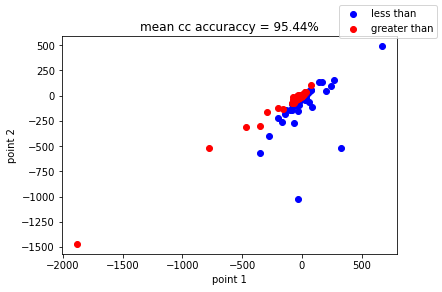

torch.Size([4571, 11])

Train Loss: 0.038	Test Loss: 0.031: 100%|██████████| 200/200 [00:05<00:00, 37.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508164590>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508164410>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


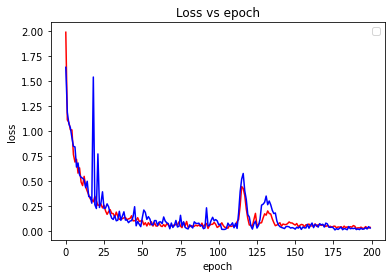

Train Class #: tensor([2655,   87])
Test Class #: tensor([1754,   75])


99.7812294902647

<Figure size 432x288 with 0 Axes>

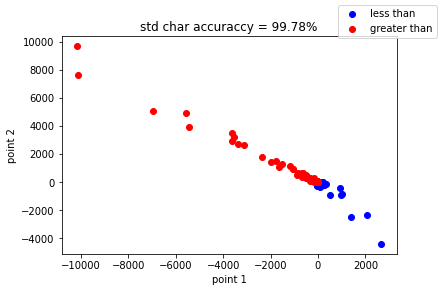

torch.Size([4571, 11])

Train Loss: 0.030	Test Loss: 0.030: 100%|██████████| 200/200 [00:05<00:00, 37.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950afc1090>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950afc1f10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


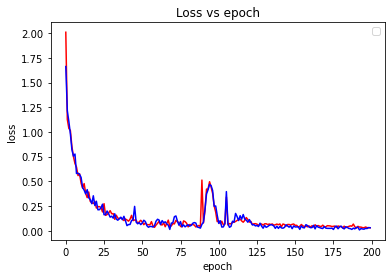

Train Class #: tensor([2653,   89])
Test Class #: tensor([1754,   75])


99.7812294902647

<Figure size 432x288 with 0 Axes>

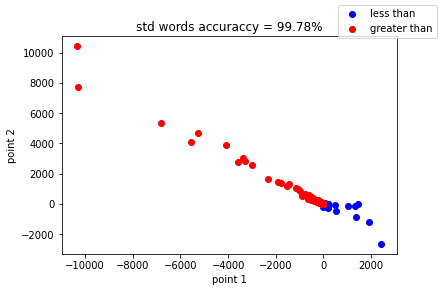

torch.Size([4571, 11])

Train Loss: 0.138	Test Loss: 0.320: 100%|██████████| 200/200 [00:05<00:00, 39.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95083899d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508389f10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


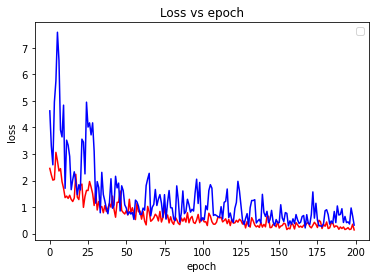

Train Class #: tensor([2678,   64])
Test Class #: tensor([1781,   48])


98.38109822795887

<Figure size 432x288 with 0 Axes>

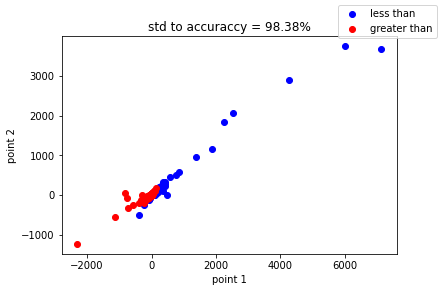

torch.Size([4571, 11])

Train Loss: 0.230	Test Loss: 0.940: 100%|██████████| 200/200 [00:05<00:00, 37.98it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950c24a710>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950bec53d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


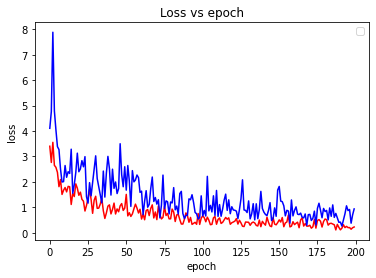

Train Class #: tensor([2691,   51])
Test Class #: tensor([1784,   45])


98.38109822795887

<Figure size 432x288 with 0 Axes>

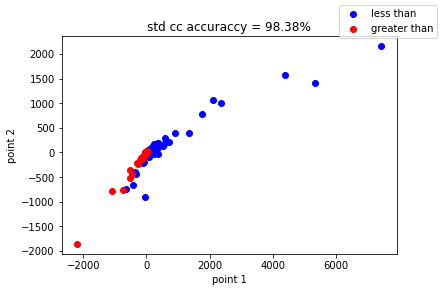

torch.Size([4571, 11])

Train Loss: 0.020	Test Loss: 0.013: 100%|██████████| 200/200 [00:05<00:00, 38.35it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508128bd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508128b90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


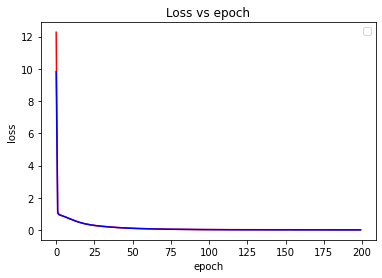

Train Class #: tensor([2435,  307])
Test Class #: tensor([1605,  224])


99.73747538831765

<Figure size 432x288 with 0 Axes>

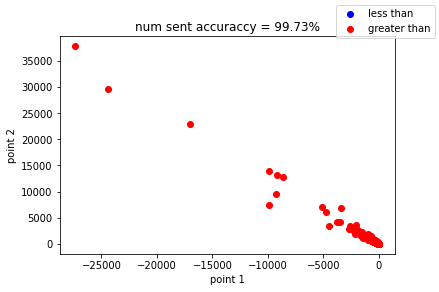

torch.Size([4571, 11])

Train Loss: 0.381	Test Loss: 0.425: 100%|██████████| 200/200 [00:05<00:00, 39.17it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95081bd650>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95081bdb90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


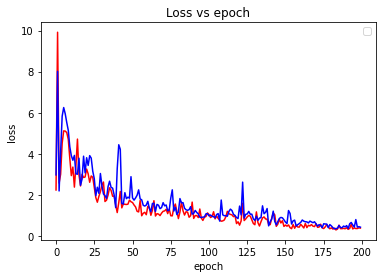

Train Class #: tensor([2326,  416])
Test Class #: tensor([1552,  277])


96.78407350689127

<Figure size 432x288 with 0 Axes>

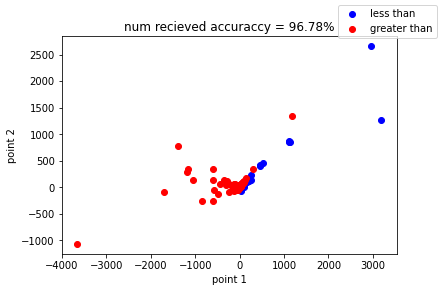

In [207]:
#this is meant to generate results for the original methods

titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(df_nodes_test, df_node_meta_test, bi_classes_test[i])
  create_edges_txt(df_edges_test)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='none')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  #trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  trainer = GNN_Node_Trainer(all_2012_graph,num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes_test[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  plt.xlabel('point 1')
  plt.ylabel('point 2')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()
  


torch.Size([4571, 11])

Train Loss: 0.151	Test Loss: 0.172: 100%|██████████| 200/200 [00:04<00:00, 44.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950c72a310>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950a71f510>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


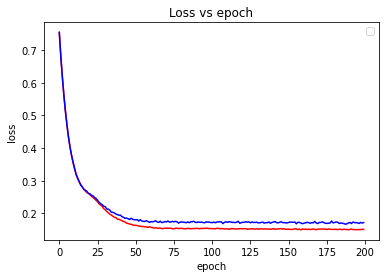

Train Class #: tensor([3294,  362])
Test Class #: tensor([826,  89])


96.06213082476482

<Figure size 432x288 with 0 Axes>

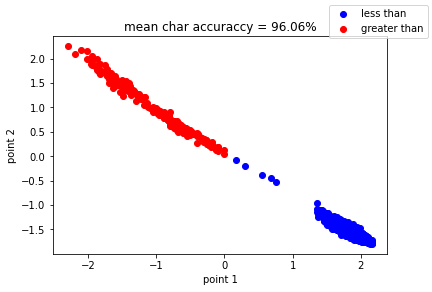

torch.Size([4571, 11])

Train Loss: 0.149	Test Loss: 0.177: 100%|██████████| 200/200 [00:04<00:00, 44.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508126810>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508126d50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


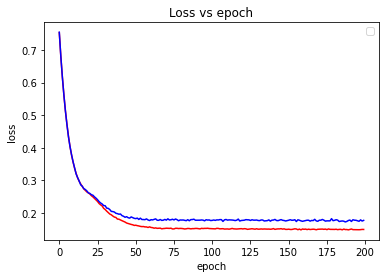

Train Class #: tensor([3292,  364])
Test Class #: tensor([826,  89])


96.10588492671188

<Figure size 432x288 with 0 Axes>

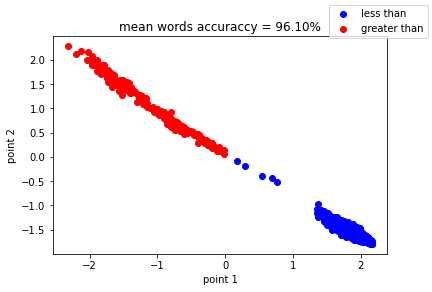

torch.Size([4571, 11])

Train Loss: 0.006	Test Loss: 0.007: 100%|██████████| 200/200 [00:04<00:00, 43.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950890f190>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950890f8d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


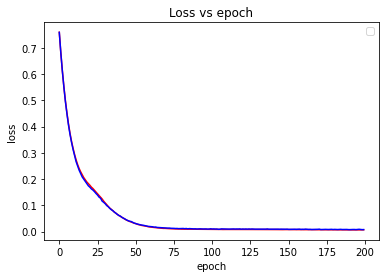

Train Class #: tensor([3395,  261])
Test Class #: tensor([854,  61])


99.95624589805294

<Figure size 432x288 with 0 Axes>

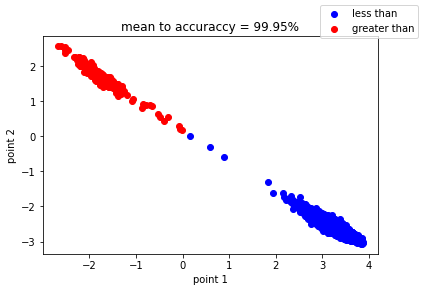

torch.Size([4571, 11])

Train Loss: 0.007	Test Loss: 0.008: 100%|██████████| 200/200 [00:04<00:00, 44.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95081ccc10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95081e5290>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


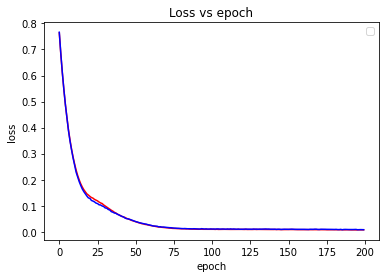

Train Class #: tensor([3518,  138])
Test Class #: tensor([885,  30])


99.95624589805294

<Figure size 432x288 with 0 Axes>

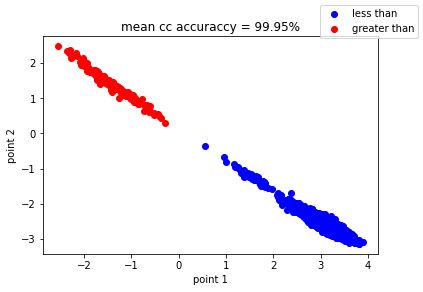

torch.Size([4571, 11])

Train Loss: 0.042	Test Loss: 0.037: 100%|██████████| 200/200 [00:04<00:00, 42.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95088c7790>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95088c7f10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


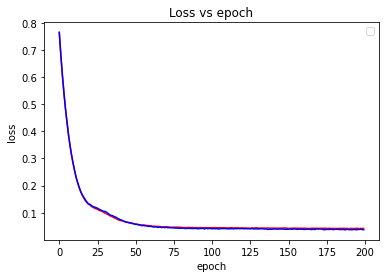

Train Class #: tensor([3527,  129])
Test Class #: tensor([882,  33])


99.10304091008533

<Figure size 432x288 with 0 Axes>

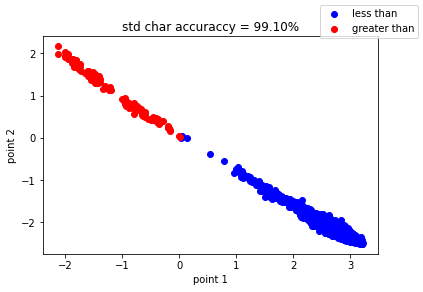

torch.Size([4571, 11])

Train Loss: 0.044	Test Loss: 0.042: 100%|██████████| 200/200 [00:04<00:00, 42.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950bf07a50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950bf07f90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


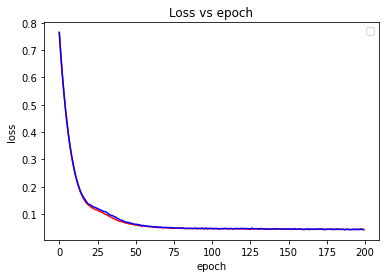

Train Class #: tensor([3526,  130])
Test Class #: tensor([881,  34])


99.05928680813827

<Figure size 432x288 with 0 Axes>

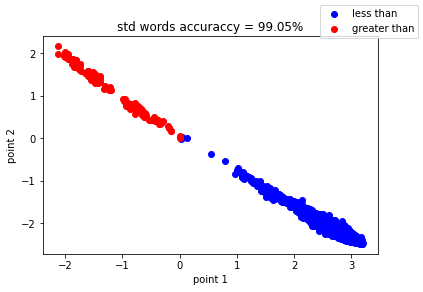

torch.Size([4571, 11])

Train Loss: 0.007	Test Loss: 0.008: 100%|██████████| 200/200 [00:04<00:00, 42.94it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950becb5d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950becb510>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


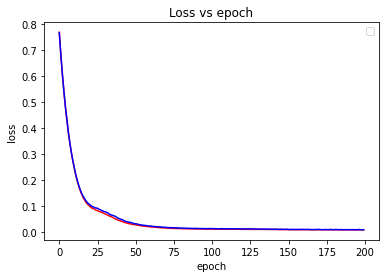

Train Class #: tensor([3568,   88])
Test Class #: tensor([891,  24])


99.93436884707941

<Figure size 432x288 with 0 Axes>

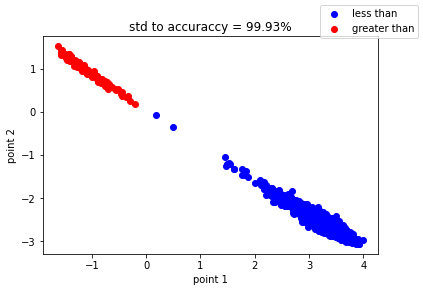

torch.Size([4571, 11])

Train Loss: 0.007	Test Loss: 0.007: 100%|██████████| 200/200 [00:04<00:00, 42.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95080f9990>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95080f9f10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


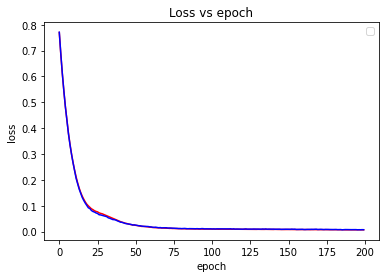

Train Class #: tensor([3577,   79])
Test Class #: tensor([898,  17])


99.95624589805294

<Figure size 432x288 with 0 Axes>

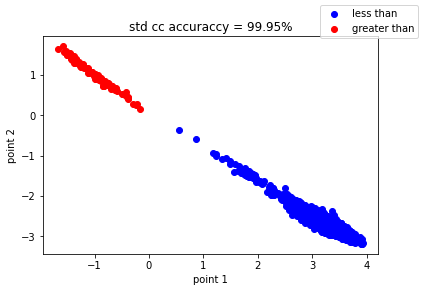

torch.Size([4571, 11])

Train Loss: 0.138	Test Loss: 0.171: 100%|██████████| 200/200 [00:04<00:00, 42.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950c717150>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950c1a76d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


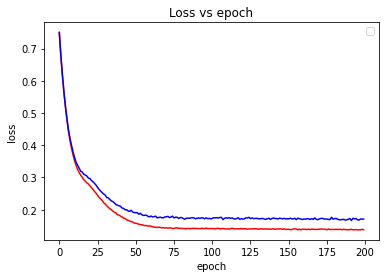

Train Class #: tensor([3236,  420])
Test Class #: tensor([804, 111])


96.6528112010501

<Figure size 432x288 with 0 Axes>

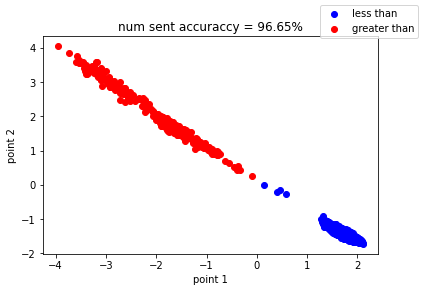

torch.Size([4571, 11])

Train Loss: 0.315	Test Loss: 0.370: 100%|██████████| 200/200 [00:04<00:00, 41.82it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508cc0e90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508cc02d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


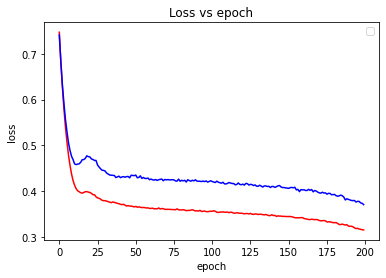

Train Class #: tensor([3128,  528])
Test Class #: tensor([750, 165])


87.88011376066507

<Figure size 432x288 with 0 Axes>

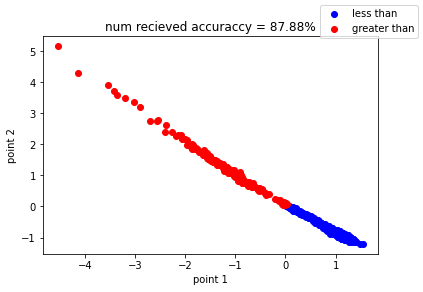

In [208]:
#this is meant to generate results for the email data set with scaled attributes


titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(df_nodes_test, scaled_df_node_meta_test, bi_classes_test_scaled[i])
  create_edges_txt(df_edges_test)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='none')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes_test_scaled[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  plt.xlabel('point 1')
  plt.ylabel('point 2')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()
  


torch.Size([4559, 11])

Train Loss: 0.113	Test Loss: 0.079: 100%|██████████| 200/200 [00:05<00:00, 37.59it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950928ef50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950928e9d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


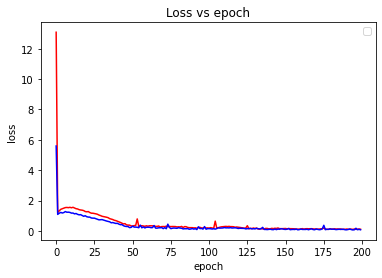

Train Class #: tensor([3280,  367])
Test Class #: tensor([829,  83])


98.74972581706514

<Figure size 432x288 with 0 Axes>

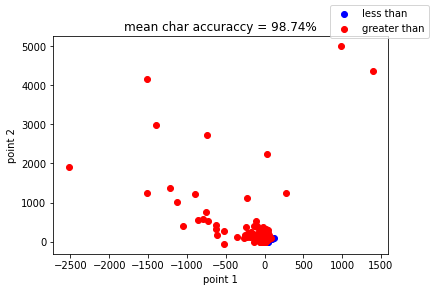

torch.Size([4559, 11])

Train Loss: 0.162	Test Loss: 0.104: 100%|██████████| 200/200 [00:05<00:00, 38.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950bf0de90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950bf28510>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


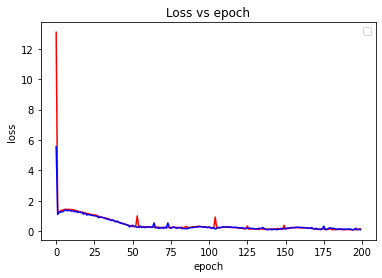

Train Class #: tensor([3275,  372])
Test Class #: tensor([830,  82])


98.66198727791182

<Figure size 432x288 with 0 Axes>

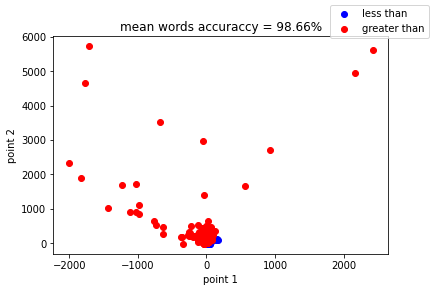

torch.Size([4559, 11])

Train Loss: 0.449	Test Loss: 0.419: 100%|██████████| 200/200 [00:04<00:00, 44.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95081f1e90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950a018c50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


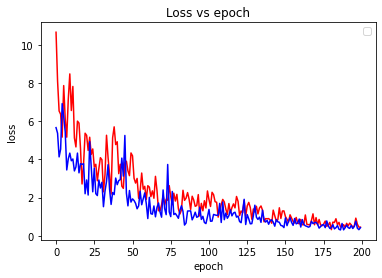

Train Class #: tensor([3386,  261])
Test Class #: tensor([858,  54])


95.48146523360386

<Figure size 432x288 with 0 Axes>

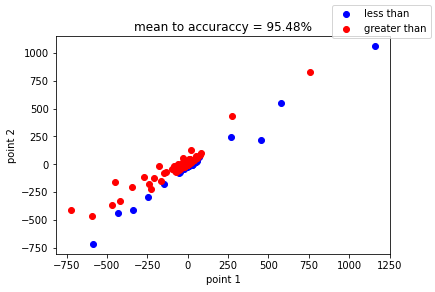

torch.Size([4559, 11])

Train Loss: 0.462	Test Loss: 0.483: 100%|██████████| 200/200 [00:04<00:00, 41.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508d02790>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508d02cd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


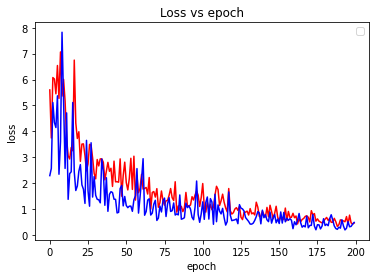

Train Class #: tensor([3514,  133])
Test Class #: tensor([878,  34])


96.0737003728888

<Figure size 432x288 with 0 Axes>

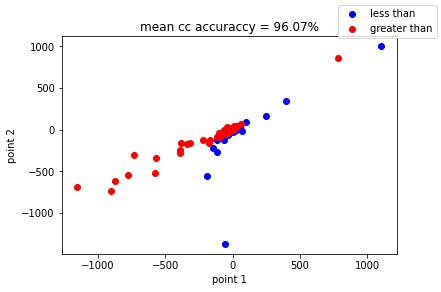

torch.Size([4559, 11])

Train Loss: 0.016	Test Loss: 0.054: 100%|██████████| 200/200 [00:05<00:00, 35.96it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508c13fd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508c13f90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


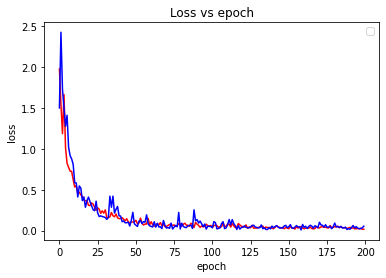

Train Class #: tensor([3521,  126])
Test Class #: tensor([880,  32])


99.82452292169336

<Figure size 432x288 with 0 Axes>

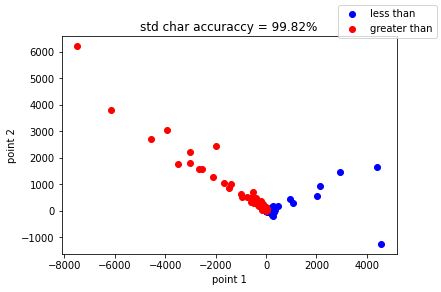

torch.Size([4559, 11])

Train Loss: 0.047	Test Loss: 0.099: 100%|██████████| 200/200 [00:05<00:00, 36.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95081e7650>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95081e7b90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


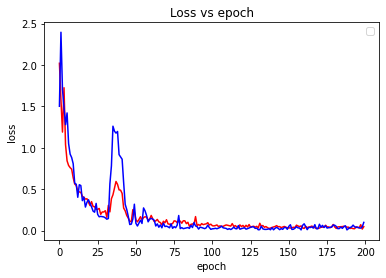

Train Class #: tensor([3519,  128])
Test Class #: tensor([880,  32])


99.7806536521167

<Figure size 432x288 with 0 Axes>

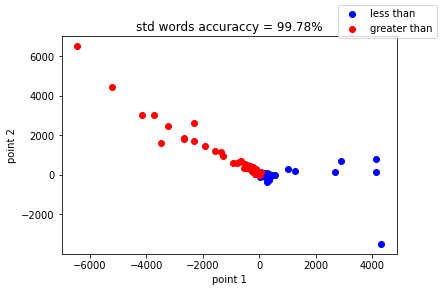

torch.Size([4559, 11])

Train Loss: 0.291	Test Loss: 0.828: 100%|██████████| 200/200 [00:05<00:00, 37.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508639f50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95092d0e90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


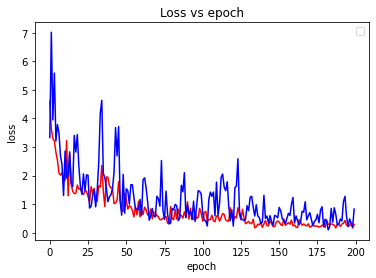

Train Class #: tensor([3559,   88])
Test Class #: tensor([890,  22])


98.61811800833516

<Figure size 432x288 with 0 Axes>

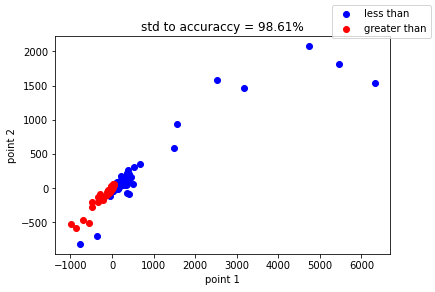

torch.Size([4559, 11])

Train Loss: 0.352	Test Loss: 0.614: 100%|██████████| 200/200 [00:05<00:00, 35.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95086498d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508649e10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


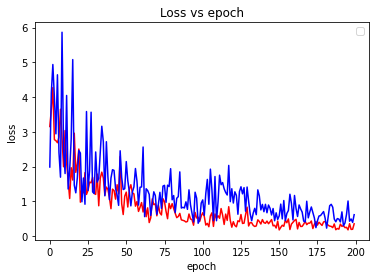

Train Class #: tensor([3575,   72])
Test Class #: tensor([889,  23])


98.70585654748848

<Figure size 432x288 with 0 Axes>

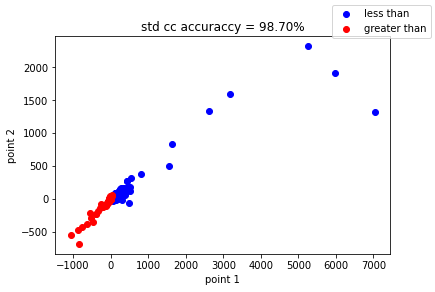

torch.Size([4559, 11])

Train Loss: 0.007	Test Loss: 0.007: 100%|██████████| 200/200 [00:05<00:00, 38.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950a81f750>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95081f1450>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


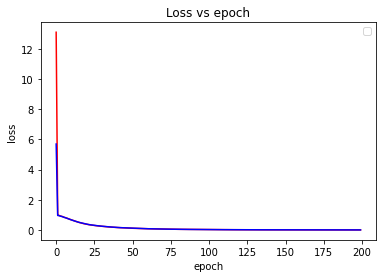

Train Class #: tensor([3222,  425])
Test Class #: tensor([818,  94])


99.97806536521166

<Figure size 432x288 with 0 Axes>

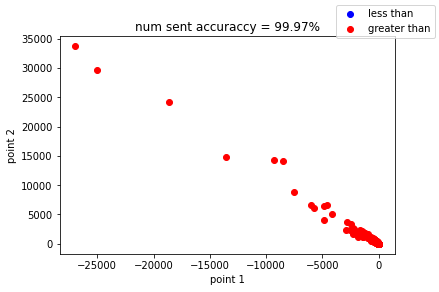

torch.Size([4559, 11])

Train Loss: 0.478	Test Loss: 0.372: 100%|██████████| 200/200 [00:05<00:00, 38.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95081e9bd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95081d2150>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


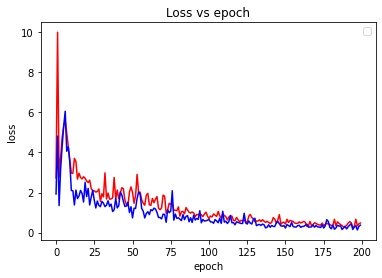

Train Class #: tensor([3083,  564])
Test Class #: tensor([785, 127])


97.58719017328362

<Figure size 432x288 with 0 Axes>

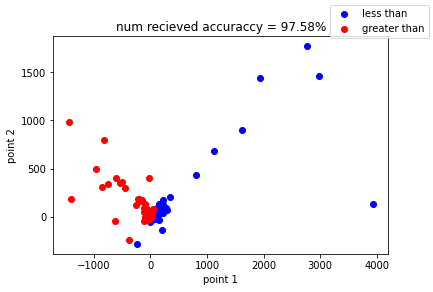

In [209]:
#this is meant to generate results for the email dataset with the char and word outliers removed


titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(df_nodes_test_wo_outliers, df_node_meta_test_wo_outliers, bi_classes_test_wo_outliers[i])
  create_edges_txt(df_edges_test_wo_outliers)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='none')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes_test_wo_outliers[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  plt.xlabel('point 1')
  plt.ylabel('point 2')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()
  


torch.Size([4559, 11])

Train Loss: 0.155	Test Loss: 0.149: 100%|██████████| 200/200 [00:04<00:00, 44.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9509293e90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9509293650>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


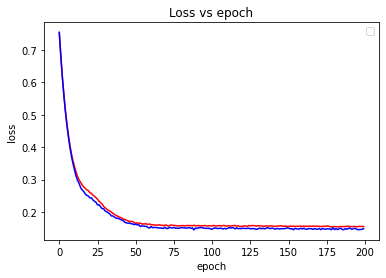

Train Class #: tensor([3280,  367])
Test Class #: tensor([829,  83])


96.11756964246545

<Figure size 432x288 with 0 Axes>

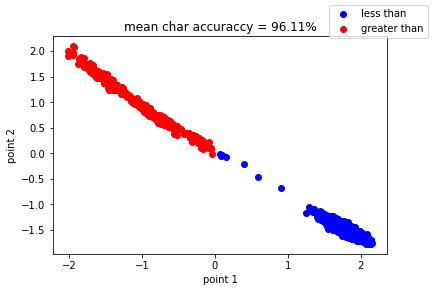

torch.Size([4559, 11])

Train Loss: 0.155	Test Loss: 0.146: 100%|██████████| 200/200 [00:04<00:00, 45.39it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508c11090>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508c115d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


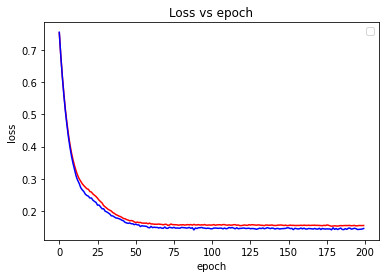

Train Class #: tensor([3275,  372])
Test Class #: tensor([830,  82])


96.18337354683044

<Figure size 432x288 with 0 Axes>

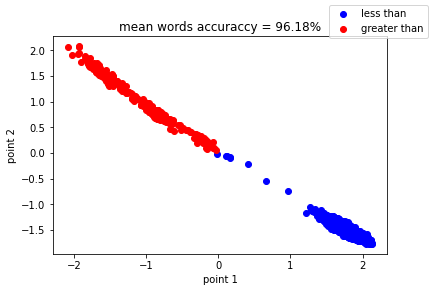

torch.Size([4559, 11])

Train Loss: 0.006	Test Loss: 0.007: 100%|██████████| 200/200 [00:04<00:00, 43.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95092b5c10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508374b90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


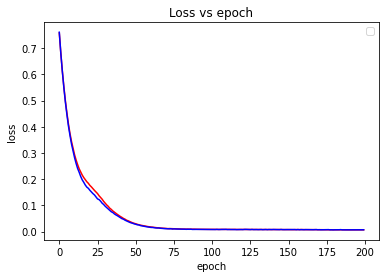

Train Class #: tensor([3386,  261])
Test Class #: tensor([858,  54])


99.97806536521166

<Figure size 432x288 with 0 Axes>

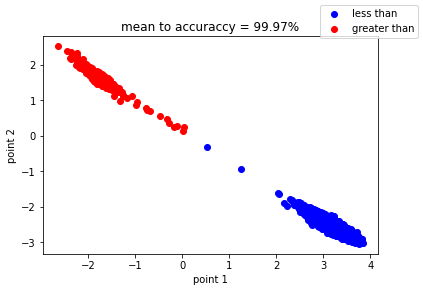

torch.Size([4559, 11])

Train Loss: 0.007	Test Loss: 0.011: 100%|██████████| 200/200 [00:04<00:00, 44.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95088d3f10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95088d83d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


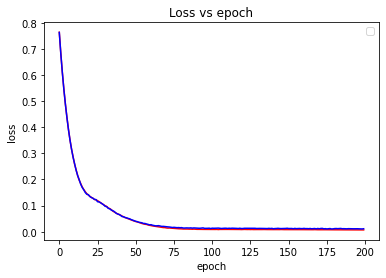

Train Class #: tensor([3514,  133])
Test Class #: tensor([878,  34])


99.95613073042334

<Figure size 432x288 with 0 Axes>

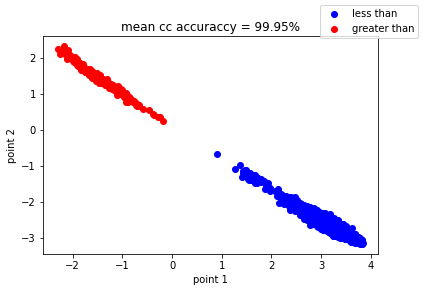

torch.Size([4559, 11])

Train Loss: 0.038	Test Loss: 0.041: 100%|██████████| 200/200 [00:04<00:00, 44.17it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950a43f6d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950a7130d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


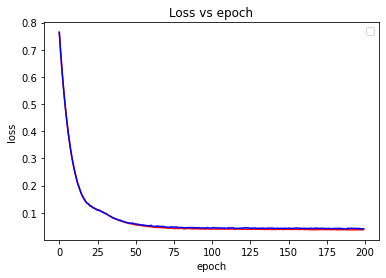

Train Class #: tensor([3521,  126])
Test Class #: tensor([880,  32])


99.18841851283176

<Figure size 432x288 with 0 Axes>

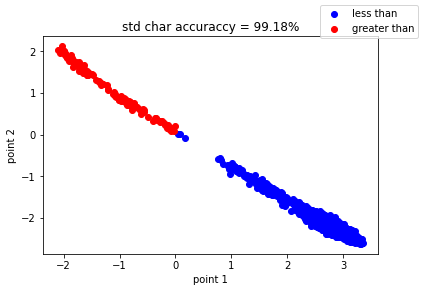

torch.Size([4559, 11])

Train Loss: 0.041	Test Loss: 0.042: 100%|██████████| 200/200 [00:04<00:00, 42.93it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508c21c50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f9508bf51d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


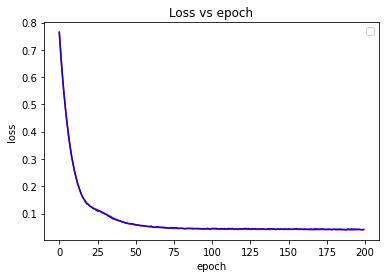

Train Class #: tensor([3519,  128])
Test Class #: tensor([880,  32])


99.1445492432551

<Figure size 432x288 with 0 Axes>

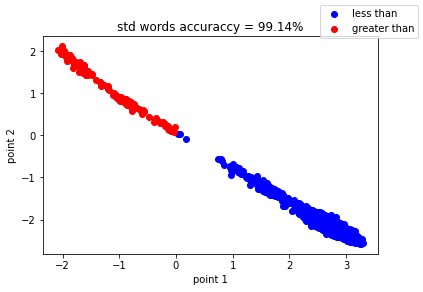

torch.Size([4559, 11])

Train Loss: 0.007	Test Loss: 0.007: 100%|██████████| 200/200 [00:04<00:00, 42.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950a7a7b10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950a7a7d90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


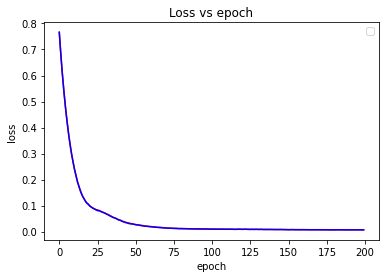

Train Class #: tensor([3559,   88])
Test Class #: tensor([890,  22])


99.95613073042334

<Figure size 432x288 with 0 Axes>

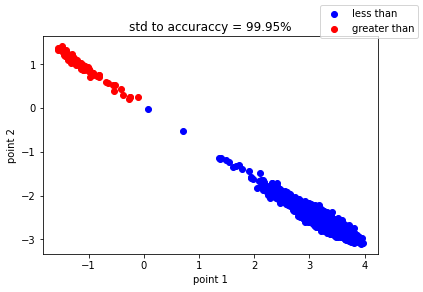

torch.Size([4559, 11])

Train Loss: 0.006	Test Loss: 0.011: 100%|██████████| 200/200 [00:04<00:00, 42.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95081bfc50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f95081b7150>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


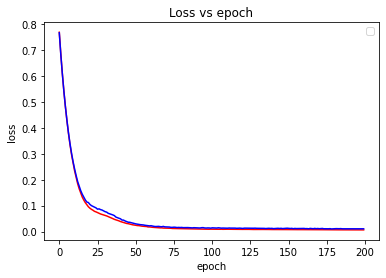

Train Class #: tensor([3575,   72])
Test Class #: tensor([889,  23])


99.95613073042334

<Figure size 432x288 with 0 Axes>

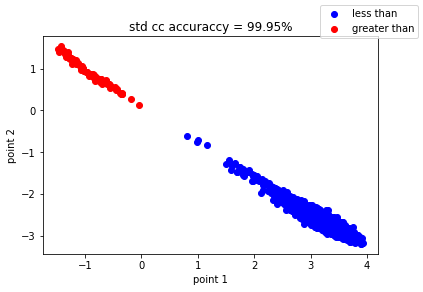

torch.Size([4559, 11])

Train Loss: 0.142	Test Loss: 0.142: 100%|██████████| 200/200 [00:04<00:00, 42.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950c19f890>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950c71d590>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


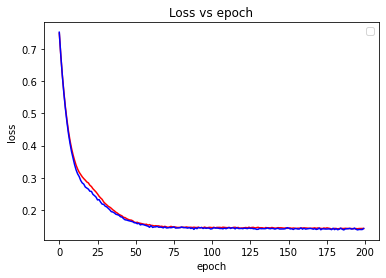

Train Class #: tensor([3222,  425])
Test Class #: tensor([818,  94])


96.77560868611538

<Figure size 432x288 with 0 Axes>

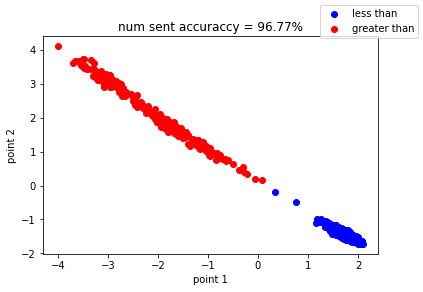

torch.Size([4559, 11])

Train Loss: 0.315	Test Loss: 0.291: 100%|██████████| 200/200 [00:04<00:00, 42.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950811a850>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f950811ad90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


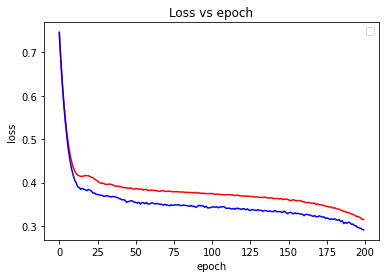

Train Class #: tensor([3083,  564])
Test Class #: tensor([785, 127])


88.2430357534547

<Figure size 432x288 with 0 Axes>

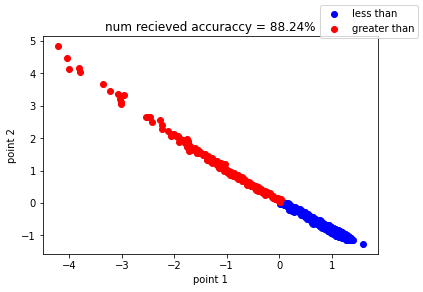

In [210]:
#this is meant to generate results for the email dataset with outliers removed and the attributes scaled


titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(df_nodes_test_wo_outliers, scaled_df_node_meta_test_wo_outliers, bi_classes_test_wo_outliers_scaled[i])
  create_edges_txt(df_edges_test_wo_outliers)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='none')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes_test_wo_outliers_scaled[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  plt.xlabel('point 1')
  plt.ylabel('point 2')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()
  


In [216]:
#this is meant to generate results for the original methods 
#I am repeating this to demonstrate the error with regards to the aggregation function

titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(df_nodes_test, df_node_meta_test, bi_classes_test[i])
  create_edges_txt(df_edges_test)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='mean')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  #trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  trainer = GNN_Node_Trainer(all_2012_graph,num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes_test[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  plt.xlabel('point 1')
  plt.ylabel('point 2')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()

torch.Size([4571, 11])

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: ignored

In [215]:
#this is meant to generate results for the email dataset with the char and word outliers removed


titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(df_nodes_test_wo_outliers, df_node_meta_test_wo_outliers, bi_classes_test_wo_outliers[i])
  create_edges_txt(df_edges_test_wo_outliers)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='mean')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes_test_wo_outliers[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  plt.xlabel('point 1')
  plt.ylabel('point 2')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()
  

torch.Size([4559, 11])

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: ignored